# Convert italian pay slip (cedolino paga) pdf to a structure

In [386]:
iname = 'cedolino.pdf'

import cv2
# pip install opencv-contrib-python
from imutils import contours
import imutils
import numpy as np
import pytesseract
import re
import string
import time
from matplotlib import pyplot as plt
from pdf2image import convert_from_path
from io import BytesIO
from PIL import Image  # pip install Pillow
from IPython.core.display import display, HTML
import base64
import ipyplot
from difflib import SequenceMatcher

In [387]:
def resize(img, width = 300):
    h= img.shape[0]
    w= img.shape[1]
    rw = width
    if w<rw: rw = w
    aratio = rw/w
    # resized = cv2.resize(img,(rw,rh)) # ,interpolation=cv2.INTER_LANCZOS4)
    resized = cv2.resize(img,None,fx=aratio,fy=aratio,interpolation=cv2.INTER_AREA)
    return resized

def show(img, title = None, width = 300):
    if not title is None:
        print(title)
    resized = resize(img,width)
    display(Image.fromarray(resized))

In [388]:
# very slow method
def imshow(imageArray, name):
     _, png = cv2.imencode('.png', imageArray)
     encoded = base64.b64encode(png)
     return HTML(data='''<img alt="{0}" src="data:image/png;base64, {1}"/>'''.format(name, encoded.decode('ascii')))

In [389]:
def is_gray(img):
    if len(img.shape) < 3: return True
    if img.shape[2]  == 1: return True
    b,g,r = img[:,:,0], img[:,:,1], img[:,:,2]
    if (b==g).all() and (b==r).all(): return True
    return False

In [390]:
def simple_crop(img):
    if not is_gray(img):
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    else:
        gray = img.copy()
    gray = 255*(gray < 128).astype(np.uint8) # To invert the text to white
    coords = cv2.findNonZero(gray) # Find all non-zero points (text)
    x, y, w, h = cv2.boundingRect(coords) # Find minimum spanning bounding box
    rect = img[y:y+h, x:x+w] # Crop the image - note we do this on the original image
    return rect

In [391]:
def dilation(src):
    kernel = np.ones((8,8), np.uint8)
    result = cv2.dilate(img,kernel,iterations=1)
    return result

def erosion(src):
    kernel = np.ones((2,2),np.uint8)
    result = cv2.erode(img,kernel,iterations=1)
    return result

In [392]:
pages=convert_from_path(iname,dpi=600,poppler_path = r"D:\Program Files (x86)\poppler-21.03.0\Library\bin")

with BytesIO() as f:
	pages[0].save(f,format="png")
	f.seek(0)
	pdf=np.array(Image.open(f).convert('RGB'))

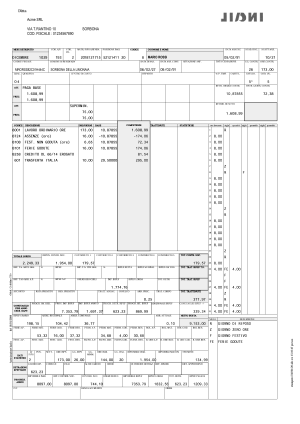

In [393]:
show(pdf)

In [394]:
# Thresholding the image
img = cv2.cvtColor(pdf, cv2.COLOR_BGR2GRAY)
#(thresh, img_bin) = cv2.threshold(img, 128, 255,cv2.THRESH_BINARY|cv2.THRESH_OTSU)
#img_bin = 255-img_bin
blocksize = 21 # 35
constant = 4 # 15
max_value = 255 # 8 bits
img_bin = cv2.adaptiveThreshold(img, max_value, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV, blocksize, constant)

In [395]:
# Defining a kernel length
kernel_length = np.array(img).shape[1]//80
 
# A verticle kernel of (1 X kernel_length), which will detect all the verticle lines from the image.
verticle_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (1, kernel_length))

# A horizontal kernel of (kernel_length X 1), which will help to detect all the horizontal line from the image.
hori_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (kernel_length, 1))

# A kernel of (3 X 3) ones.
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))

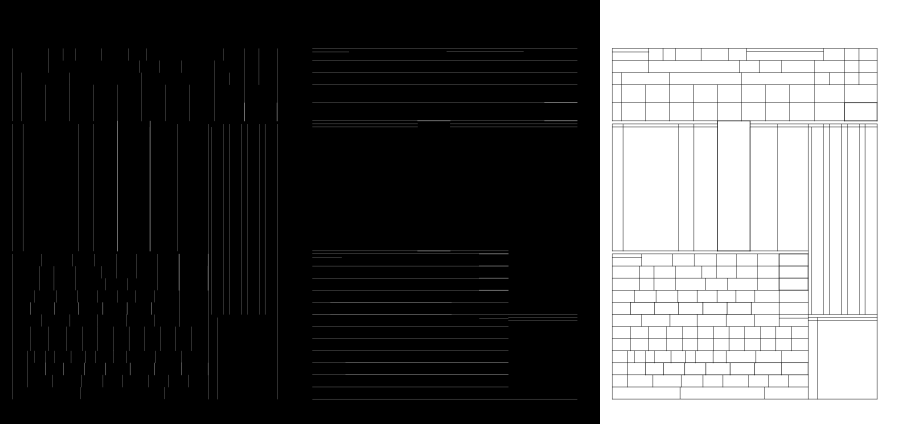

In [396]:
# Morphological operation to detect vertical lines from an image
img_temp1 = cv2.erode(img_bin, verticle_kernel, iterations=3)
verticle_lines_img = cv2.dilate(img_temp1, verticle_kernel, iterations=3)

# Morphological operation to detect horizontal lines from an image
img_temp2 = cv2.erode(img_bin, hori_kernel, iterations=3)
horizontal_lines_img = cv2.dilate(img_temp2, hori_kernel, iterations=3)

# Weighting parameters, this will decide the quantity of an image to be added to make a new image.
alpha = 0.5
beta = 1.0 - alpha

# This function helps to add two image with specific weight parameter to get a third image as summation of two image.
img_final_bin = cv2.addWeighted(verticle_lines_img, alpha, horizontal_lines_img, beta, 0.0)
img_final_bin = cv2.erode(~img_final_bin, kernel, iterations=2)
(thresh, img_final_bin) = cv2.threshold(img_final_bin, 128,255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)

result = cv2.hconcat([verticle_lines_img, horizontal_lines_img, img_final_bin])
show(result, width = 900)

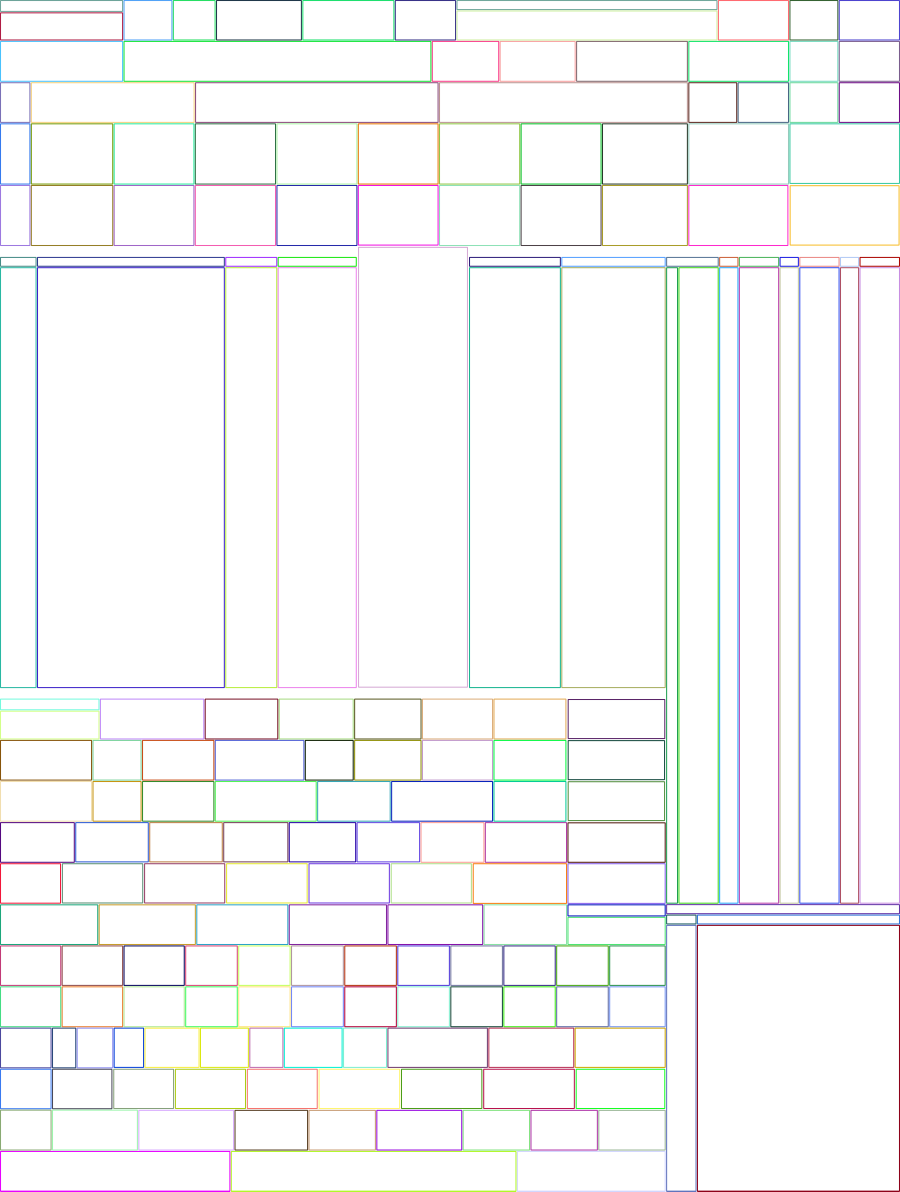

In [397]:
# Find contours for image, which will detect all the boxes
# the RETR_LIST doesn't match the desired inner retcangle where they overlap perfectly
# looking as two adiacent rectangles instead of one the smaller as title of the container
# nctrs, hierarchy = cv2.findContours(img_final_bin, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
nctrs, hierarchy = cv2.findContours(img_final_bin, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

# Sort all the contours by top to bottom.
(nctrs, boundingBoxes) =  contours.sort_contours(nctrs, method="top-to-bottom")

# cv.drawContours(img, contours, -1, (0,255,0), 3)

# show interested contours
size = pdf.shape
maxw = size[0]/2
result = np.zeros(pdf.shape,dtype=np.uint8)
result[:] = 255

for b in boundingBoxes:
    x,y,w,h = b
    if w<maxw:
        color = list(np.random.random(size=3) * 256)
        cv2.rectangle(result, (x, y), (x + w, y + h), color, 4)
    
show(simple_crop(result),width = 900)

In [398]:
def reduce_space(gray, pixel_value=255):
    original = gray.copy()
    blur = cv2.GaussianBlur(gray, (3,3), 0)
    thresh = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1]
    invert = 255 - thresh  
    height, width = gray.shape[:2]

    # Dilate with a horizontal kernel to connect text contours
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (10,2))
    dilate = cv2.dilate(thresh, kernel, iterations=2)
    
    lines = []
    cnts = cv2.findContours(dilate, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    # cnts = cv2.findContours(dilate, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    
    # ################################################################ #
    # it fail when there is a thin line that connect more rectangles
    # so it dobule some content
    # ################################################################ #
    
    cnts = cnts[0] if len(cnts) == 2 else cnts[1]
    (cnts, _) = contours.sort_contours(cnts, method="top-to-bottom")
    for c in cnts:
        x,y,w,h = cv2.boundingRect(c)
        cv2.rectangle(gray, (0, y), (width, y+h), (36,255,12), 2)
        line = original[y:y+h, 0:width]
        # line = cv2.cvtColor(line, cv2.COLOR_BGR2GRAY)
        lines.append(line)
        show(line)
    
    # Append white space in between each line
    space = np.ones((1, width), dtype=np.uint8) * 255
    result = np.zeros((0, width), dtype=np.uint8)
    result = np.concatenate((result, space), axis=0)
    for line in lines:
        if np.mean(line) != 255: # if not empty
            result = np.concatenate((result, line), axis=0)
            result = np.concatenate((result, space), axis=0)
    
    return result

In [399]:
def remove_white_lines(img, pixel_value=255):
    if not is_gray(img):
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    else:
        gray = img.copy()
    crop_rows = gray[~np.all(gray == pixel_value, axis=1), :]
    cropped_image = crop_rows[:, ~np.all(crop_rows == pixel_value, axis=0)]
    return cropped_image

"get_one_image" is not used because tesseract does a worst job even if it is faster

In [400]:
def get_one_image(img_list, padding = 50):
    
        max_width = []
        max_height = 0
        for img in img_list:
            max_width.append(img.shape[1])
            max_height += img.shape[0] + padding
        w = np.max(max_width)
        h = max_height

        # create a new array with a size large enough to contain all the images
        final_image = np.zeros((h, w), dtype=np.uint8)
        final_image[:] = 255
        
        # add a dashed line to separate images
        if padding!=0:
            pad = np.ones((padding, w), dtype=np.uint8) * 255
            cv2.putText(pad, '----------------', (0, 35), cv2.FONT_HERSHEY_SCRIPT_COMPLEX, 1, (0,0,0), 2)

        current_y = 0  # keep track of where your current image was last placed in the y coordinate
        idx = 0
        for image in img_list:
            idx+=1
            # add an image to the final array and increment the y coordinate
            final_image[current_y:current_y + image.shape[0], :image.shape[1]] = image
            current_y += image.shape[0] 
            if padding!=0:
                final_image[current_y:current_y + padding, :pad.shape[1]] = pad
                current_y += padding
           
        return final_image

In [401]:
img_list = []
bordersize = 10
gray = cv2.cvtColor(pdf, cv2.COLOR_BGR2GRAY)
for c in nctrs:
    # Returns the location and width,height for every contour
    x, y, w, h = cv2.boundingRect(c)
    if (w < maxw and w>0 and h>0):
        new_img = gray[y:y+h, x:x+w]
        #(thresh, bw_img) = cv2.threshold(new_img, 127, 255,cv2.THRESH_BINARY)
        bw_img = cv2.adaptiveThreshold(
            new_img, max_value, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 
            blocksize, constant
        )
        if np.mean(bw_img) != 255: # if not empty
            bordered = np.zeros((bw_img.shape[0] + bordersize,bw_img.shape[1] + bordersize) ,dtype=np.uint8)
            bordered[:] = 255
            x = y = int(bordersize/2)
            bordered[y:y+h, x:x+w] = bw_img
            img_list.append(bordered)

if len(img_list) == 0: print("No images added")

In [402]:
# for img in img_list: show(img)
# final = get_one_image(img_list, 0); show( final )
# txt=normalize(pytesseract.image_to_string(final, lang='ita'))
# print(txt)
# ipyplot.plot_images(img_list,img_width = 100) # this give an error

In [403]:
regex = re.compile('[^A-Z0-9\-/,.%€ \r\n]')
def normalize(s):
    txt = re.sub(regex,'',s).replace("\n\n","\n").replace("  "," ")
    # strings = txt.split("\n")
    strings = "".join([s for s in txt.strip().splitlines(True) if s.strip()])
    return strings

In [404]:
custom_oem_psm_config = r'' #--oem 0' # --psm 6'
html = "<table>"
for img in img_list:
    txt=normalize(pytesseract.image_to_string(img, lang='ita', config=custom_oem_psm_config))
    # show(img)
    add = False
    if txt != "":
        add = True
        
    else:
        
        imgd = dilation(img)
        txt=normalize(pytesseract.image_to_string(imgd, lang='ita', config=custom_oem_psm_config))
        
        if txt != "":
            
            add =True
            
        else:
            
            imge = erosion(img)
            txt=normalize(pytesseract.image_to_string(imge, lang='ita', config=custom_oem_psm_config))
            if txt != "": add = True
                
    if add and txt!="" and txt!="%":
        html += '<tr><td>'
        oimg = simple_crop(img)
        if oimg.shape[0]==0 or oimg.shape[1]==0: oimg = img
        oimg = resize(remove_white_lines(oimg),width=200)
        _, png = cv2.imencode('.png', oimg)
        encoded = base64.b64encode(png)
        height, width = oimg.shape[:2]
        if width>height: 
            width="200px";height="auto"            
        else:
            width="auto";height="100px"
        html += '<img style="width:{0};height:{1}" src="data:image/png;base64, {2}"/>'.format(width,height,encoded.decode('ascii'))
        html += '</td><td>{0}</td></tr>'.format(txt.replace("\n","<br>"))
            
html += '</table>'
display(HTML(html))